In [1]:
import sys
import IPython.display

In [2]:
sys.path.insert(0, "/home/mai/zkhan/ALBEF")

In [3]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from models.tokenization_bert import BertTokenizer
from models.singlestream_v2.baseline_retrieval import ALBEF

In [5]:
import json
import random
import ruamel.yaml as yaml
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import spacy

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
from dataset.utils import pre_caption

In [8]:
with open('/net/acadia10a/data/zkhan/cc12m-json/100k.json', 'r') as f:
    cc100k = json.load(f)

In [37]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/ablations/Pretrain4M_SharedTxtEncoder.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/mai/zkhan/ALBEF/configs/shared_bert.json'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_pseudolabels_multimodal_mim_momentum/checkpoint_29.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]                
msg = model.load_state_dict(state_dict,strict=False) 

device = torch.device('cuda')
model.eval();
model = model.to(device)

/home/mai/zkhan/miniconda3/envs/ssl/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


reshape position embedding from 196 to 256
_IncompatibleKeys(missing_keys=['mask_token'], unexpected_keys=['head.weight', 'head.bias'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from t

Some weights of BertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.3.crossattention.self.value.weight', 'bert.encoder.layer.5.crossattention.self.key.weight', 'bert.encoder.layer.5.crossattention.self.value.bias', 'bert.encoder.layer.11.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.4.crossattention.self.value.weight', 'bert.encoder.layer.3.crossattention.output.dense.weight', 'bert.encoder.layer.5.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.2.crossattention.self.query.weight', 'bert.encoder.layer.9.crossattention.self.query.weight', 'bert.encoder.layer.6.crossattention.output.dense.weight', 'bert.encoder.layer.2.crossattention.self.key.bias', 'bert.encoder.layer.1.crossattention.self.key.weight', 'bert.encoder.layer.8.crossattention.self.query.weight', 'bert.encoder.layer.11.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder

In [38]:
word_embeddings = F.normalize(model.text_encoder.embeddings.word_embeddings.weight, dim=1)

An informational sign stands in from of a historic wooden building.


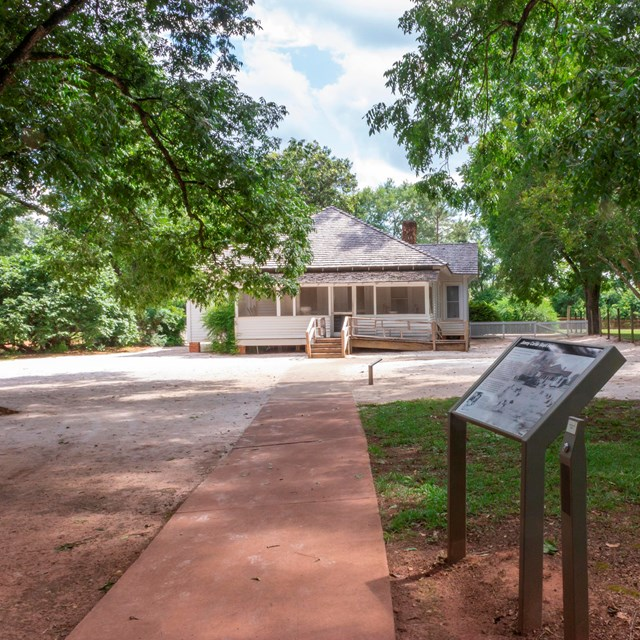

In [158]:
sample = random.choice(cc100k)
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [159]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

In [160]:
caption = pre_caption(sample['caption'], 30)
caption

'an informational sign stands in from of a historic wooden building'

In [161]:
image = image.to(device)

In [162]:
text = tokenizer(caption, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)

In [163]:
image_embeds = model.visual_encoder(image.unsqueeze(0))
#image_embeds = F.normalize(image_embeds, dim=1)
image_embeds.shape

torch.Size([1, 257, 768])

In [164]:
image_atts = torch.ones(image_embeds.shape[:-1]).to(device)
image_atts.shape

torch.Size([1, 257])

In [165]:
with torch.no_grad():
    model_output = model.text_encoder(
        text.input_ids, 
        attention_mask=text.attention_mask,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_atts,
        return_dict=True, mode='multimodal',
        output_attentions=True
    )

In [166]:
len(model_output.attentions)

12

In [167]:
model_output.attentions[0].shape

torch.Size([1, 12, 13, 13])

<AxesSubplot:>

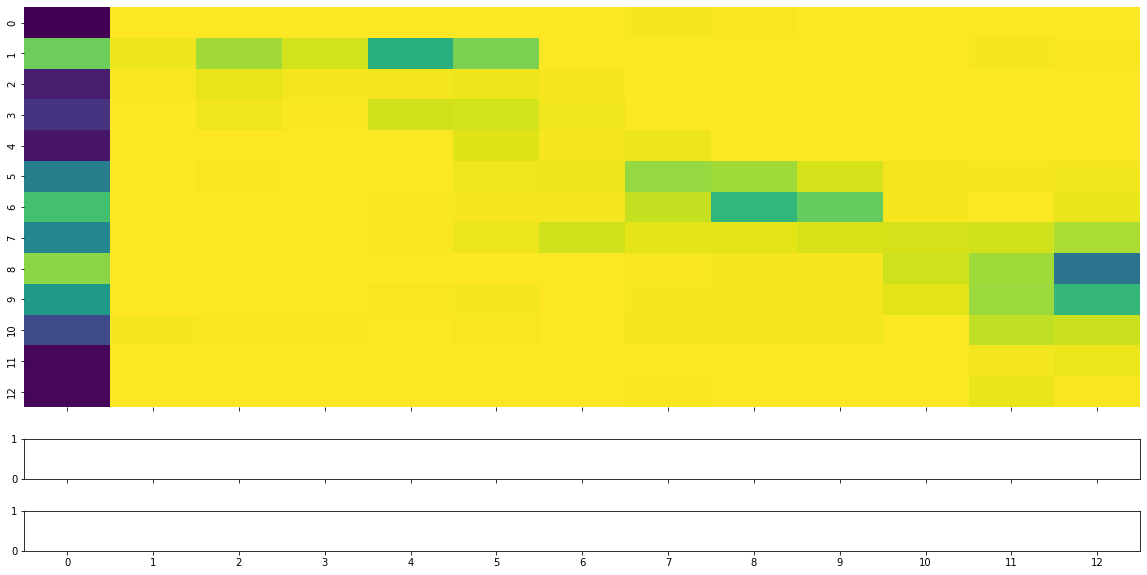

In [168]:
head = 5
level = 0
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': (10, 1, 1)})
sns.heatmap(model_output.attentions[head].squeeze()[level].cpu().numpy(), ax=ax1, cbar=False, cmap='viridis_r')
#sns.heatmap(token_type_ids.cpu().numpy(), ax=ax2, cbar=False, cmap='rainbow')
#ax3.bar(np.arange(token_type_ids.shape[-1]), model_output.attentions[head].squeeze()[level].cpu().numpy().sum(axis=0))

Text(0.5, 1.0, 'Patches closest to house')

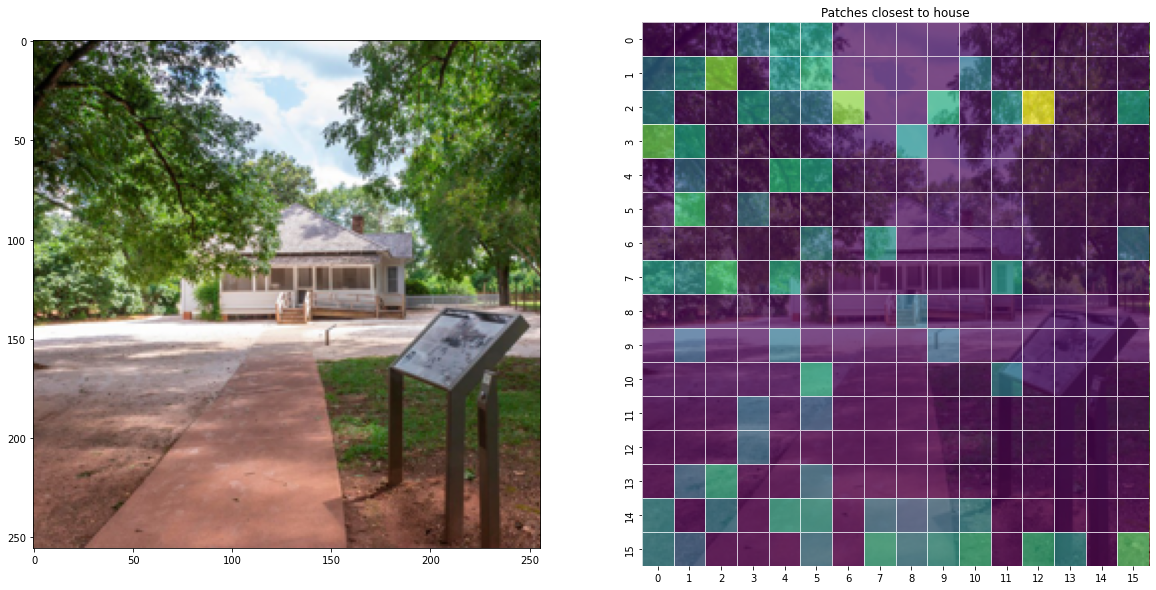

In [169]:
vis_word_embeds = F.normalize(image_embeds.squeeze(), dim=1)
sims = vis_word_embeds @ word_embeddings.T
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
literal_word = 'house'
search_word = word_embeddings[tokenizer.encode(literal_word)[-1]]
sim_map = (search_word @ vis_word_embeds.T).detach().cpu().numpy()[1:].reshape(16, 16)
threshold = np.percentile(sim_map.flatten(), 75)
sim_map[sim_map < threshold] = 0
sns.heatmap(sim_map, cbar=False, ax=ax2, zorder=5, linewidths=.5, alpha=.7, cmap='viridis')
ax2.imshow(view_image.permute(1,2,0),
          aspect = ax2.get_aspect(),
          extent = ax2.get_xlim() + ax2.get_ylim(),
          zorder = 1) #put the map under the heatmap
ax1.imshow(view_image.permute(1,2,0))
plt.title(f'Patches closest to {literal_word}')

In [144]:
[tokenizer.decode(_) for _ in sims.topk(10, dim=-1).indices]

['person only her hair make man like re scene s',
 'accessories length throughout av alongside into champced sachal',
 '##edlessces bernhard side avcedフ₂ steel',
 'back champ horse lights gasmel at av s tap',
 'gasostal aved back gold indianapolis champpel',
 '##less trailer support dramahd श lights hip backs car',
 'back gas at population payrollyslessos stmel',
 '##less lane car hostility aspened doubtlitped diplomats',
 'gold carless dramami at snow only velvet hanging',
 'background covered built christmas at near are real lined together',
 'aspen car lane diplomatsped onlyedᆸlessmed',
 'aspen s only like av lanevi ladder gas salisbury',
 'gas oilback street horse agingless frame face faces',
 'lane gas oil horse aspen lights car truck man drivers',
 '##edvi aspenom faceledeshd gas snow',
 'aspen lane gas diplomatslesslitporgy dramas reserves',
 'av gasfp backs driversless drivertalvieve',
 '##ceslessed bikingpor steel payroll av mechanized ज',
 'at background christmas are back is

In [147]:
sim_map.min()

-0.04822644

In [151]:
sim_map.flatten().shape

(256,)